In [1]:
import warnings

warnings.simplefilter("ignore")

# PostBOUND Demo

In [2]:
import networkx as nx
import postbound as pb
import seaborn as sns

In [3]:
pg_instance = pb.postgres.connect(config_file="../.psycopg_connection_stats")
pg_instance

stats @ postgres (v17.3)

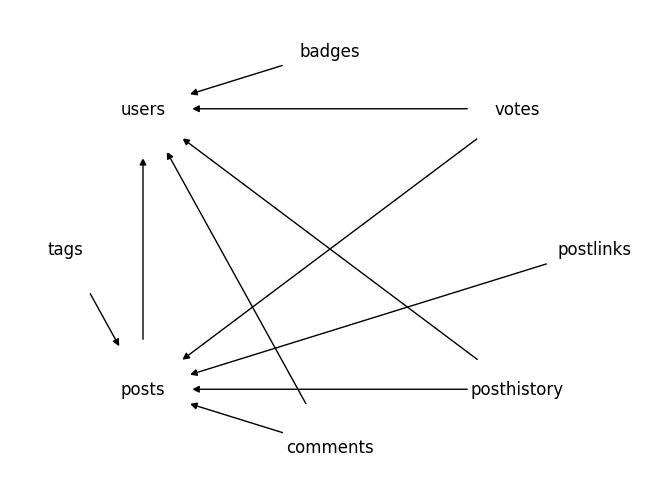

In [4]:
nx.draw_shell(
    pg_instance.schema().as_graph(), with_labels=True, node_size=5000, node_color="#FFF"
)

In [5]:
posts = pb.TableReference("posts", "p")
posts_score = pb.ColumnReference("score", posts)
votes = pb.TableReference("votes", "v")

In [6]:
pg_instance.statistics().most_common_values(posts_score)

[(1, 23221),
 (0, 20196),
 (2, 15478),
 (3, 10068),
 (4, 6320),
 (5, 4208),
 (6, 2893),
 (7, 1975),
 (8, 1331),
 (9, 973)]

## Phase 1: Query Preparation

In [7]:
sample = pb.parse_query("""
    SELECT count(*)
    FROM Posts p, Users u
    WHERE p.OwnerUserId = u.Id
    AND p.Score > 10
""")
sample

SELECT COUNT(*) FROM posts AS p, users AS u WHERE p.owneruserid = u.id AND p.score > 10;

In [8]:
stats = pb.workloads.stats()
stats

Workload: Stats (146 queries)

In [9]:
print(pb.qal.format_quick(stats["q-111"]))

SELECT COUNT(*)
FROM comments AS c,
  postlinks AS pl,
  posthistory AS ph,
  votes AS v,
  posts AS p
WHERE pl.postid = p.id
  AND c.postid = p.id
  AND v.postid = p.id
  AND ph.postid = p.id
  AND pl.linktypeid = 1
  AND pl.creationdate >= CAST('2010-10-19 15:02:42' AS timestamp)
  AND ph.creationdate <= CAST('2014-06-18 17:14:07' AS timestamp)
  AND v.creationdate >= CAST('2010-07-20 00:00:00' AS timestamp);


### Query Abstraction

In [10]:
stats["q-111"].predicates().joins_for(posts)

[v.postid = p.id, ph.postid = p.id, pl.postid = p.id, c.postid = p.id]

### Join Graphs

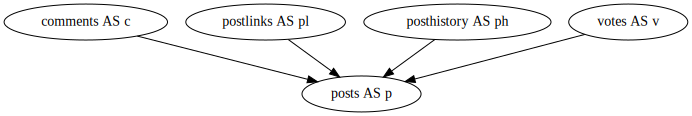

In [11]:
from postbound import vis

join_graph = pb.opt.joingraph.JoinGraph(stats["q-111"])
vis.opt.plot_join_graph(join_graph, include_pk_fk_joins=True)

In [12]:
join_graph.join_predicates_between(posts, votes)

{v.postid = p.id}

### Relational Algebra

In [13]:
relnode = pb.relalg.parse_relalg(sample)
relnode

Projection(GroupBy(ThetaJoin(Selection(p), u)))

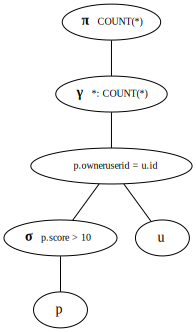

In [14]:
vis.opt.plot_relalg(relnode)

## Phase 2: Query Optimization

In [15]:
print(pb.qal.format_quick(stats["q-10"]))

SELECT COUNT(*)
FROM comments AS c, posts AS p, users AS u
WHERE c.userid = u.id
  AND u.id = p.owneruserid
  AND c.creationdate >= CAST('2010-08-05 00:36:02' AS timestamp)
  AND c.creationdate <= CAST('2014-09-08 16:50:49' AS timestamp)
  AND p.viewcount >= 0
  AND p.viewcount <= 2897
  AND p.commentcount >= 0
  AND p.commentcount <= 16
  AND p.favoritecount >= 0
  AND p.favoritecount <= 10;


In [16]:
from postbound.optimizer.strategies import native

native_join_order = native.NativeJoinOrderOptimizer(pg_instance)
native_operators = native.NativePhysicalOperatorSelection(pg_instance)

In [17]:
pipeline = (
    pb.MultiStageOptimizationPipeline(pg_instance)
    .setup_join_order_optimization(native_join_order)
    .setup_physical_operator_selection(native_operators)
    .build()
)
pipeline

MultiStageOptimization [NativeJoinOrderOptimizer -> NativePhysicalOperatorSelection -> None]

In [18]:
optimized = pipeline.optimize_query(stats["q-10"])
optimized

/*+
  Leading(((c u) p))
  
  SeqScan(c)
  IndexOnlyScan(u)
  IndexOnlyScan(p)
  
  NestLoop(u c p)
  HashJoin(u c)
  
*/
SELECT COUNT(*) FROM comments AS c, posts AS p, users AS u WHERE c.userid = u.id AND u.id = p.owneruserid AND c.creationdate >= CAST('2010-08-05 00:36:02' AS timestamp) AND c.creationdate <= CAST('2014-09-08 16:50:49' AS timestamp) AND p.viewcount >= 0 AND p.viewcount <= 2897 AND p.commentcount >= 0 AND p.commentcount <= 16 AND p.favoritecount >= 0 AND p.favoritecount <= 10;

In [19]:
optimized_plan = pg_instance.optimizer().query_plan(optimized)
print(optimized_plan.ast())

Aggregate
  ->  Gather
    ->  Aggregate
      ->  Nested Loop
        ->  Hash Join
          ->  Seq Scan(comments AS c)
          ->  Hash
            ->  Index Only Scan(users AS u)
        ->  Memoize
          ->  Index Scan(posts AS p)


In [20]:
native_plan = pg_instance.optimizer().query_plan(stats["q-10"])
print(native_plan.ast())

Aggregate
  ->  Gather
    ->  Aggregate
      ->  Nested Loop
        ->  Hash Join
          ->  Seq Scan(comments AS c)
          ->  Hash
            ->  Index Only Scan(users AS u)
        ->  Memoize
          ->  Index Scan(posts AS p)


## Phase 4: Benchmarking

In [21]:
prep = pb.experiments.QueryPreparationService(
    analyze=True, prewarm=True, preparatory_statements=["SET geqo TO off;"]
)

In [22]:
results = pb.optimize_and_execute_workload(
    stats.first(5),
    pipeline,
    workload_repetitions=3,
    shuffled=True,
    query_preparation=prep,
    include_labels=True,
)

In [23]:
results

,label,execution_index,query,workload_iteration,query_repetition,optimization_time,exec_time,query_result,optimization_success,optimization_failure_reason,original_query,optimization_settings,db_config
0,q-3,1,"SELECT COUNT(*) FROM comments AS c, posthistor...",1,1,0.009576,0.287717,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, posthistor...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
1,q-4,2,"SELECT COUNT(*) FROM comments AS c, posthistor...",1,1,0.006419,0.211832,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, posthistor...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
2,q-2,3,"SELECT COUNT(*) FROM comments AS c, badges AS ...",1,1,0.007262,0.611784,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, badges AS ...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
3,q-5,4,"SELECT COUNT(*) FROM comments AS c, votes AS v...",1,1,0.005597,0.424837,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, votes AS v...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
4,q-1,5,"SELECT COUNT(*) FROM badges AS b, users AS u W...",1,1,0.005401,0.035467,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM badges AS b, users AS u W...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
5,q-5,6,"SELECT COUNT(*) FROM comments AS c, votes AS v...",2,1,0.003770,0.394978,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, votes AS v...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
6,q-2,7,"SELECT COUNT(*) FROM comments AS c, badges AS ...",2,1,0.003290,0.560983,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, badges AS ...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
7,q-4,8,"SELECT COUNT(*) FROM comments AS c, posthistor...",2,1,0.002914,0.200203,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, posthistor...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
8,q-3,9,"SELECT COUNT(*) FROM comments AS c, posthistor...",2,1,0.003141,0.231267,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, posthistor...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
9,q-1,10,"SELECT COUNT(*) FROM badges AS b, users AS u W...",2,1,0.002804,0.024672,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM badges AS b, users AS u W...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."


In [24]:
avg_runtimes = results.groupby("label", as_index=False)["exec_time"].mean()
avg_runtimes

,label,exec_time
0,q-1,0.029531
1,q-2,0.560631
2,q-3,0.247490
3,q-4,0.200631
4,q-5,0.392477


<Axes: xlabel='label', ylabel='exec_time'>

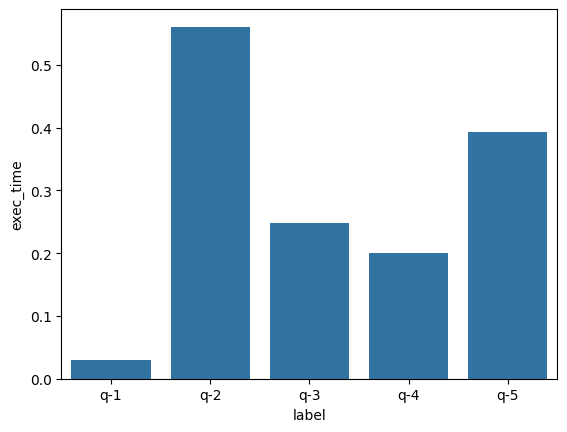

In [25]:
sns.barplot(avg_runtimes, x="label", y="exec_time")